In [1]:
import os
import sys
import time
import math
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from scipy import integrate, signal, stats, fftpack
from glob import glob
from datetime import date
import mne

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, get_evoked_traces, find_nearest_ind

from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

#### Functions

### Subjects

In [5]:
## All subjects ##
group_title = 'all'
PCImeancolor = 'darkblue'

sub_dirs = {
    '551399': r'F:\EEG_exp\mouse551399\estim_2021-01-28_13-59-09\experiment1\recording1',
    '551397': r'F:\EEG_exp\mouse551397\estim_vis_2021-02-11_10-45-23\experiment1\recording1',
    '569062': r'F:\EEG_exp\mouse569062\estim_vis_2021-02-18_11-17-51\experiment1\recording1',
    '569068': r'F:\EEG_exp\mouse569068\estim_vis_2021-03-04_10-51-38\experiment1\recording1',
    '569069': r'F:\EEG_exp\mouse569069\estim_vis2_2021-03-12_10-52-44\experiment1\recording1',
    '569064': r'F:\EEG_exp\mouse569064\estim_vis_2021-04-08_10-28-24\experiment1\recording1',
    '569073a': r'F:\EEG_exp\mouse569073\estim_vis_2021-04-15_10-27-22\experiment1\recording1',
    '571619a': r'F:\EEG_exp\mouse571619\estim2_2021-03-19_10-09-01\experiment1\recording1',
    '569070': r'F:\EEG_exp\mouse569070\estim1_2021-04-01_10-27-33\experiment1\recording1',
    '521885': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521885\estim1_2020-07-09_14-23-49\experiment1\recording1',
    '521886': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521886\estim1_2020-07-16_13-37-02\experiment1\recording1',
    '521887': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521887\estim1_2020-07-30_11-25-05\experiment1\recordingfull',
    '543393': r'F:\EEG_exp\mouse543393\estim1_2020-08-20_13-24-53\experiment1\recording1',
    '543394': r'F:\EEG_exp\mouse543394\estim1_2020-08-27_14-32-00\experiment1\recording1',
#     '543396': r'F:\EEG_exp\mouse543396\estim_vis1_2020-09-18_12-04-46\experiment1\recording1', # too few resting trials
    '546655': r'F:\EEG_exp\mouse546655\estim_vis_2020-10-23_11-01-14\experiment1\recording1',
#     '571618': r'F:\EEG_exp\mouse571618\estim1_2021-04-29_12-28-54\experiment1\recording1', # too many bad chs
    '575102': r'F:\EEG_exp\mouse575102\estim_vis_2021-06-03_11-25-01\experiment1\recording1',
#     '575100': r'F:\EEG_exp\mouse575100\estim_vis_2021-06-10_11-39-06\experiment1\recording1', # 100um offset stim electrode
    '571619b': r'F:\EEG_exp\mouse571619\estim2_2021-03-19_10-09-01\experiment1\recording1',
    '569073b': r'F:\EEG_exp\mouse569073\estim_2021-04-16_10-42-44\experiment1\recording1',
    '569072': r'F:\EEG_exp\mouse569072\estim_vis_2021-04-22_10-26-58\experiment1\recording1',
    '571620a': r'F:\EEG_exp\mouse571620\estim_vis_2021-05-13_11-33-47\experiment1\recording1',
    '571620b': r'F:\EEG_exp\mouse571620\estim_vis_2021-05-13_11-33-47\experiment1\recording1',
    '586466a': r'F:\EEG_exp\mouse586466\estim_vis_2021-07-29_10-37-41\experiment1\recording1',
    '586466b': r'F:\EEG_exp\mouse586466\estim_vis_2021-07-29_10-37-41\experiment1\recording1',
    '586468': r'F:\EEG_exp\mouse586468\estim_vis_2021-08-19_11-36-53\experiment1\recording1',
}

brain_states = {
    '551399': {'awake': [0], 'anesthetized': [1]},
    '551397': {'awake': [0], 'anesthetized': [1]},
    '569062': {'awake': [0], 'anesthetized': [1]},
    '569068': {'awake': [0], 'anesthetized': [1]},
    '569069': {'awake': [0], 'anesthetized': [1]},
    '569064': {'awake': [0], 'anesthetized': [1]},
    '569073a': {'awake': [0], 'anesthetized': [1]},
    '571619a': {'awake': [1], 'anesthetized': [2]},
    '569070': {'awake': [0], 'anesthetized': [1]},
    '521885': {'awake': [0], 'anesthetized': [1]},
    '521886': {'awake': [0], 'anesthetized': [1]},
    '521887': {'awake': [0, 1], 'anesthetized': [2, 3, 4]},
    '543393': {'awake': [0, 1, 2], 'anesthetized': [3, 4, 5]},
    '543394': {'awake': [0, 1, 2], 'anesthetized': [3, 4, 5]},
#     '543396': {'awake': [0], 'anesthetized': [1]},
    '546655': {'awake': [0], 'anesthetized': [1]},
#     '571618': {'awake': [0], 'anesthetized': [1]},
    '575102': {'awake': [0], 'anesthetized': [1]},
#     '575100': {'awake': [0], 'anesthetized': [1]},
    '571619b': {'awake': [0], 'anesthetized': [3]},
    '569073b': {'awake': [0], 'anesthetized': [1]},
    '569072': {'awake': [0], 'anesthetized': [1]},
    '571620a': {'awake': [0], 'anesthetized': [3]},
    '571620b': {'awake': [1], 'anesthetized': [2]},
    '586466a': {'awake': [0], 'anesthetized': [3]},
    '586466b': {'awake': [1], 'anesthetized': [2]},
    '586468': {'awake': [1], 'anesthetized': [2]},
}

#### Load Zap_Zip-log_exp to get metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

### Load experiments

In [7]:
sub_exp = {}
for mousei, recdiri in sub_dirs.items():
    sub_exp[mousei] = EEGexp(recdiri, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical and sensory stimulation
Body camera file not found.
Pupil camera file not found.
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
Experiment type: electrical and sensory stimulation
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical and sensory stimulation
Experiment 

In [8]:
# plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots'
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs'

### Load eeg data and gather stim-evoked traces

In [9]:
## parameters ##
before_event = 1. # s, look at 1 s pre-stim
after_event = 1. # s, look at 1 s post-stim

apply_mask = True
apply_hpass = True
apply_car = True

In [11]:
# start = time.time()

EEG_traces = {}
sub_good_chs = {}
PCI_stim_amp = {}
for mousei, expi in sub_exp.items():
    print(mousei[:6])
    
    ## Load stim log ##
    stim_log = pd.read_csv(expi.stimulus_log_file)
    stim_log = stim_log.astype({'parameter': str})
    amp_list = sorted(stim_log[stim_log['stim_type'] == 'biphasic'].parameter.unique(), key=lambda x: int(x))
    if len(amp_list) <= 1:
        print(' does not have multiple amplitudes, not including in analysis.\n')
        continue
    
    ## Grab exp metadata from Zap_Zip-log_exp ##
    expi_meta = zzmetadata[(
        (zzmetadata['mouse_name'].str.contains(expi.mouse[:6])) &
        (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(expi.experiment_folder))))
    )].squeeze()
    
    ## Get bad_ch_list from metadata ##
    badchstr = expi_meta['EEG bad_channels'].replace(' ','')
    bad_ch_list = []
    for char in badchstr.split(','):
        if char.isdecimal():
            bad_ch_list.append(int(char))
    
    ## Get PCI_stim_amp from metadata ##
    currentstr = expi_meta['Current (uA)'].replace(' ','')
    currents_list = []
    for char in currentstr.split('/'):
        if char.isdecimal():
            currents_list.append(int(char))
    if len(currents_list) > 1:
        PCI_stim_amp[mousei] = currents_list[1]
    elif len(currents_list) == 1:
        PCI_stim_amp[mousei] = currents_list[0]
    else:
        print('No stim current listed in Zap_Zip-log_exp')
    
    # load data ##
    datai, tsi = expi.load_eegdata()
    eegchs = np.arange(0, datai.shape[1])
    good_chs = np.array([x for x in eegchs if x not in bad_ch_list])
    
    ## Load running signal ##
    run_signal, run_timestamps = expi.load_running()
    
    ## Mask estim artifact ##
    if apply_mask:
        mask_samples = int(0.002 * expi.ephys_params['EEG']['sample_rate'])
        for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
            val = find_nearest_ind(tsi, etime) - 2
            datai[val:val+mask_samples, :] = datai[val:val-mask_samples:-1, :]
    
    start = time.time()
    ## Apply high-pass filter ##
    if apply_hpass:
        hpb, hpa = signal.butter(3, 0.1/(expi.ephys_params['EEG']['sample_rate']/2), btype='highpass')
        datai = signal.filtfilt(hpb, hpa, datai, axis=0)
    end = time.time()
    print('  time to highpass filter: {:.2f} s'.format((end - start)))
    
    ## Get evoked traces ##
    EEG_traces[mousei] = {}
    for statei, sweeps in brain_states[mousei].items():
        EEG_traces[mousei][statei] = {}
        for ampi in amp_list:
            state_events = []
            for sweepi in sweeps:
                events = get_stim_events(stim_log, 'biphasic', ampi, sweepi)
                if len(events) == 0:
                    continue
                state_events.append(events)
            state_events = np.concatenate(state_events)

            ## Get mean speed ##
            rinds = np.arange(-int(0.5 * 100), int(0.5 * 100))
            event_inds = np.array([find_nearest_ind(run_timestamps, x) for x in state_events])
            mean_speed = np.mean(run_signal[np.repeat([rinds], len(event_inds), axis=0).T + event_inds], axis=0)
            rest_events = np.nonzero(mean_speed == 0)[0]
            print(' {} state, {} ua: resting trials {:d}/{:d}'.format(statei, ampi, len(rest_events), len(state_events)))

            ## Get evoked EEG traces ##
            event_traces, event_ts = get_evoked_traces(
                datai, tsi, state_events[rest_events], before_event, after_event, expi.ephys_params['EEG']['sample_rate']
            )
            ## Apply common avg ##
            if apply_car:
                event_traces = event_traces - np.mean(event_traces[:, good_chs, :], axis=1)[:,None,:]
            ## Apply lowpass filter ##
            filtb, filta = signal.butter(3, 100/(expi.ephys_params['EEG']['sample_rate']/2), btype='low')
            EEG_traces[mousei][statei][ampi] = [event_ts, signal.filtfilt(filtb, filta, event_traces, axis=0)]
    sub_good_chs[mousei] = good_chs
            
    del datai
    del tsi
    del stim_log
    del run_signal
    del run_timestamps
    print('')

# end = time.time()
# print('Time to analyze: {:.2f} min'.format((end - start) / 60))

551399
  time to highpass filter: 27.16 s
 awake state, 40 ua: resting trials 109/118
 awake state, 60 ua: resting trials 108/120
 awake state, 80 ua: resting trials 106/120
 anesthetized state, 40 ua: resting trials 119/119
 anesthetized state, 60 ua: resting trials 120/120
 anesthetized state, 80 ua: resting trials 120/120

551397
  time to highpass filter: 33.98 s
 awake state, 10 ua: resting trials 85/120
 awake state, 30 ua: resting trials 96/120
 awake state, 50 ua: resting trials 96/120
 anesthetized state, 10 ua: resting trials 120/120
 anesthetized state, 30 ua: resting trials 120/120
 anesthetized state, 50 ua: resting trials 120/120

569062
  time to highpass filter: 29.85 s
 awake state, 15 ua: resting trials 94/120
 awake state, 35 ua: resting trials 102/120
 awake state, 60 ua: resting trials 90/120
 anesthetized state, 15 ua: resting trials 120/120
 anesthetized state, 35 ua: resting trials 119/120
 anesthetized state, 60 ua: resting trials 120/120

569068
  time to high

# Calculating EEG magnitude

For mice with multiple amplitudes

In [12]:
sstates = list(brain_states[list(brain_states.keys())[0]].keys())
amp_tags = {0: 'low', 1: 'medium', 2: 'high'}
response_win = [0.005, 0.8]
z_threshold = 5

mlist = []
state_list = []
amplitudes = []
AUC = []
RMS = []
SNR = []
duration = []
for subi in EEG_traces.keys():
    print(subi)
    start = time.time()
    
    NUM_TRIALS = min([EEG_traces[subi]['awake'][x][1].shape[2] for x in EEG_traces[subi]['awake'].keys()])
    print(' Good channels: {:d}'.format(sub_good_chs[subi].shape[0]))
    print(' Trials: {:d}'.format(NUM_TRIALS))
    
    if NUM_TRIALS < 30:
        print('Not enough trials in one/more awake sweeps, not computing EEG magnitude.')
        print('')
        continue
    
    for statei in EEG_traces[subi].keys():
        for ii, ampi in enumerate(EEG_traces[subi][statei].keys()):
#             print(' {} - {}'.format(statei, ampi))
            mlist.append(subi)
            state_list.append(statei)
            amplitudes.append(amp_tags[ii])
            
            timex = EEG_traces[subi][statei][ampi][0]
            state_traces = np.mean(EEG_traces[subi][statei][ampi][1][:, :, :NUM_TRIALS], axis=2)
            
            ## baseline and response indices ##
            preinds = np.nonzero((timex >= -response_win[1]) & (timex <= -response_win[0]))[0]
            postinds = np.nonzero((timex >= response_win[0]) & (timex <= response_win[1]))[0]
            
            ## calculate AUC ##
            baseline_auc = integrate.simps(np.abs(state_traces[preinds, :]), timex[preinds], axis=0, even='last')
            response_auc = integrate.simps(np.abs(state_traces[postinds, :]), timex[postinds], axis=0, even='last')
            actual_auc = response_auc[sub_good_chs[subi]] - baseline_auc[sub_good_chs[subi]]
            AUC.append(np.median(actual_auc))
            
            ## calculate RMS ##
            base_rms = np.sqrt(np.mean(np.square(state_traces[preinds, :]), axis=0))
            resp_rms = np.sqrt(np.mean(np.square(state_traces[postinds, :]), axis=0))
            RMS.append(np.median(resp_rms[sub_good_chs[subi]]))
            
            ## calculate SNR ##
            SNR.append(np.median((resp_rms/base_rms)[sub_good_chs[subi]]))
            
            ## calculate response duration ##
            z_traces = ((state_traces - np.mean(state_traces[preinds,:], axis=0)) / np.std(state_traces[preinds,:], axis=0))
            ch_dur = []
            for chi in sub_good_chs[subi]:
                zinds = np.nonzero(np.abs(z_traces[:,chi]) > z_threshold)[0]
                if ((zinds.size > 0) and (timex[zinds[-1]] > 0)):
                    ch_dur.append(timex[zinds[-1]])
            if len(ch_dur) > 0:
                duration.append(np.median(np.array(ch_dur)))
            else:
                duration.append(0)

    end = time.time()
    print('Time: {:.2f} s\n'.format(end-start))
    
EEGmetrics = pd.DataFrame({
    'mouse': mlist,
    'state': state_list,
    'stim amplitude': amplitudes,
    'AUC': AUC,
    'RMS': RMS,
    'SNR': SNR,
    'duration': duration
})
EEGmetrics.head()

551399
 Good channels: 22
 Trials: 106
Time: 0.82 s

551397
 Good channels: 27
 Trials: 85
Time: 0.72 s

569062
 Good channels: 28
 Trials: 90
Time: 0.75 s

569068
 Good channels: 30
 Trials: 96
Time: 0.82 s

569069
 Good channels: 30
 Trials: 78
Time: 0.84 s

569064
 Good channels: 30
 Trials: 116
Time: 0.97 s

569073a
 Good channels: 27
 Trials: 86
Time: 0.78 s

571619a
 Good channels: 25
 Trials: 97
Time: 0.78 s

569070
 Good channels: 26
 Trials: 86
Time: 0.71 s

521885
 Good channels: 17
 Trials: 47
Time: 0.41 s

521886
 Good channels: 20
 Trials: 87
Time: 0.61 s

546655
 Good channels: 22
 Trials: 38
Time: 0.11 s

575102
 Good channels: 26
 Trials: 83
Time: 0.15 s

571619b
 Good channels: 25
 Trials: 89
Time: 0.17 s

569073b
 Good channels: 18
 Trials: 81
Time: 0.17 s

569072
 Good channels: 21
 Trials: 104
Time: 0.23 s

571620a
 Good channels: 17
 Trials: 88
Time: 0.18 s

571620b
 Good channels: 17
 Trials: 104
Time: 0.16 s

586466a
 Good channels: 17
 Trials: 113
Time: 0.17 s



,mouse,state,stim amplitude,AUC,RMS,SNR,duration
0,551399,awake,low,1.614149,5.831214,3.521831,0.1644
1,551399,awake,medium,4.484518,12.663024,8.648540,0.3098
2,551399,awake,high,7.810854,17.785535,12.204372,0.3918
3,551399,anesthetized,low,0.789405,3.255888,2.032561,0.0546
4,551399,anesthetized,medium,2.166564,5.426007,5.100512,0.3558


## Plot metrics

Area under absolute curve

<IPython.core.display.Javascript object>


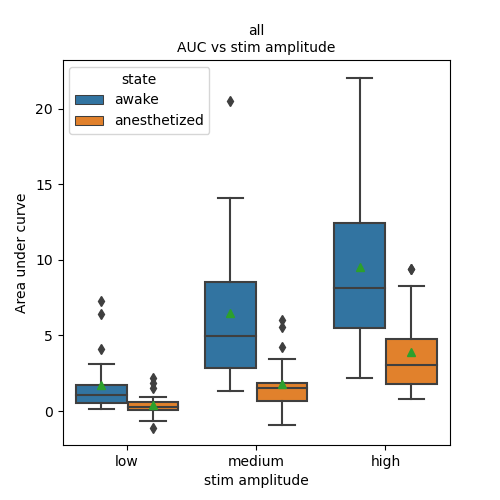

In [13]:
fig, ax = plt.subplots(figsize=(5,5))

bxplt = sns.boxplot(x='stim amplitude', y='AUC', hue='state', data=EEGmetrics, ax=ax, showmeans=True)

bxplt.set_title('{}\nAUC vs stim amplitude'.format(group_title))
bxplt.set_ylabel('Area under curve')

## Save ##
figname = 'EEGmetrics_AUC_stimamp_{}.png'.format(group_title)
fig.savefig(os.path.join(plotsdir, figname), transparent=True)

RMS of response

<IPython.core.display.Javascript object>


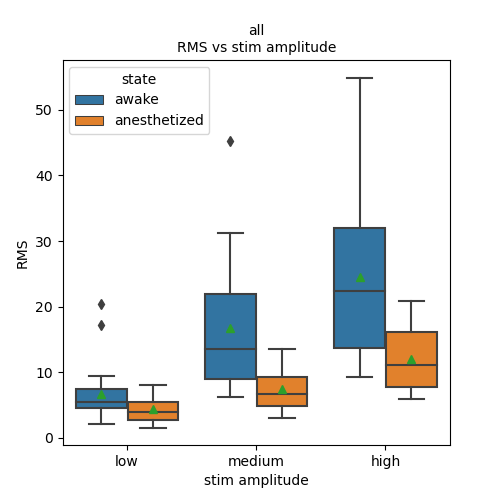

In [14]:
fig, ax = plt.subplots(figsize=(5,5))

bxplt = sns.boxplot(x='stim amplitude', y='RMS', hue='state', data=EEGmetrics, ax=ax, showmeans=True)

bxplt.set_title('{}\nRMS vs stim amplitude'.format(group_title))
bxplt.set_ylabel('RMS')

## Save ##
figname = 'EEGmetrics_RMS_stimamp_{}.png'.format(group_title)
fig.savefig(os.path.join(plotsdir, figname), transparent=True)

SNR of response compared to baseline

<IPython.core.display.Javascript object>


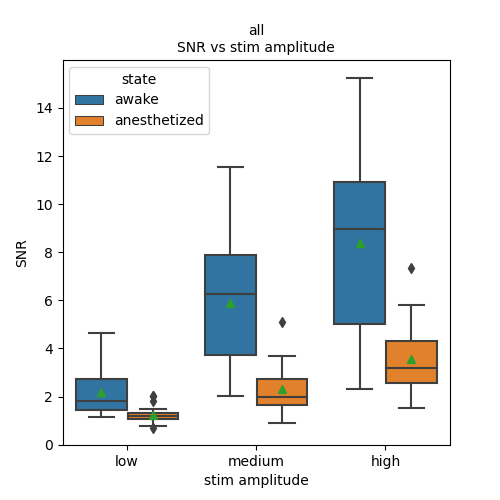

In [15]:
fig, ax = plt.subplots(figsize=(5,5))

bxplt = sns.boxplot(x='stim amplitude', y='SNR', hue='state', data=EEGmetrics, ax=ax, showmeans=True)

bxplt.set_title('{}\nSNR vs stim amplitude'.format(group_title))
bxplt.set_ylabel('SNR')

## Save ##
figname = 'EEGmetrics_SNR_stimamp_{}.png'.format(group_title)
fig.savefig(os.path.join(plotsdir, figname), transparent=True)

Duration of response above z threshold

<IPython.core.display.Javascript object>


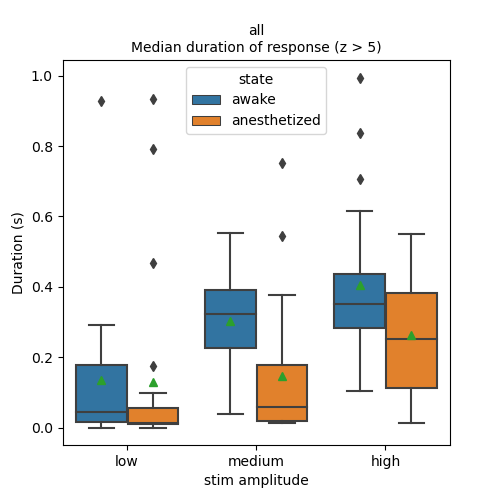

In [16]:
fig, ax = plt.subplots(figsize=(5,5))

bxplt = sns.boxplot(x='stim amplitude', y='duration', hue='state', data=EEGmetrics, ax=ax, showmeans=True)

bxplt.set_title('{}\nMedian duration of response (z > {:d})'.format(group_title, z_threshold))
bxplt.set_ylabel('Duration (s)')

## Save ##
figname = 'EEGmetrics_duration_stimamp_{}.png'.format(group_title)
fig.savefig(os.path.join(plotsdir, figname), transparent=True)

# Calculating PCI for each amplitude

In [17]:
sstates = list(brain_states[list(brain_states.keys())[0]].keys())
amp_tags = {0: 'low', 1: 'medium', 2: 'high'}
response_win = [0.005, 0.8]
z_threshold = 5

mlist = []
amplitudes = []
deltaPCI = []

PCI_params = {
    'baseline_window': (-0.8, -0.001), # s before stim for baseline, my default: (-0.5, -0.001)
    'response_window': (0.001, 0.8), # s after stim for response, my default: (0.001, 0.5)
    'k': 1.2,
    'min_snr': 1.6, # my default: 1.1
    'max_var': 99,
    'embed': False,
    'n_steps': 100,
}

for subject in EEG_traces.keys():
    print(subject)
    start = time.time()
    
    NUM_TRIALS = min([EEG_traces[subject]['awake'][x][1].shape[2] for x in EEG_traces[subject]['awake'].keys()])
    print(' Good channels: {:d}'.format(sub_good_chs[subject].shape[0]))
    print(' Trials: {:d}'.format(NUM_TRIALS))
    
    if NUM_TRIALS < 30:
        print('Not enough trials, not computing PCI.')
        print('')
        continue
    
    for ii, ampi in enumerate(EEG_traces[subject]['awake'].keys()):
        mlist.append(subject)
        amplitudes.append(amp_tags[ii])
        
        subPCI = {}
        for statei in sstates:
            state_traces = np.mean(EEG_traces[subject][statei][ampi][1][:, :, :NUM_TRIALS], axis=2)

            ## Calculate PCIst ##
            subPCI[statei] = calc_PCIst(
                state_traces[:, sub_good_chs[subject]].T,
                EEG_traces[subject][statei][ampi][0],
                full_return=False,
                **PCI_params
            )

        deltaPCI.append(subPCI['awake'] - subPCI['anesthetized'])
    end = time.time()
    print('Time: {:.2f} s'.format(end-start))
    print('')
    
EEG_PCI = pd.DataFrame({
    'mouse': mlist,
    'stim amplitude': amplitudes,
    'delta_PCI': deltaPCI,
})
EEG_PCI.head()

551399
 Good channels: 22
 Trials: 106
Time: 364.26 s

551397
 Good channels: 27
 Trials: 85
Time: 303.03 s

569062
 Good channels: 28
 Trials: 90
Time: 326.21 s

569068
 Good channels: 30
 Trials: 96
Time: 162.05 s

569069
 Good channels: 30
 Trials: 78
Time: 270.09 s

569064
 Good channels: 30
 Trials: 116
Time: 390.42 s

569073a
 Good channels: 27
 Trials: 86
Time: 340.15 s

571619a
 Good channels: 25
 Trials: 97
Time: 349.38 s

569070
 Good channels: 26
 Trials: 86
Time: 297.79 s

521885
 Good channels: 17
 Trials: 47
Time: 300.63 s

521886
 Good channels: 20
 Trials: 87
Time: 208.76 s

546655
 Good channels: 22
 Trials: 38
Time: 434.74 s

575102
 Good channels: 26
 Trials: 83
Time: 394.18 s

571619b
 Good channels: 25
 Trials: 89
Time: 231.31 s

569073b
 Good channels: 18
 Trials: 81
Time: 301.68 s

569072
 Good channels: 21
 Trials: 104
Time: 338.80 s

571620a
 Good channels: 17
 Trials: 88
Time: 170.54 s

571620b
 Good channels: 17
 Trials: 104
Time: 491.65 s

586466a
 Good chan

,mouse,stim amplitude,delta_PCI
0,551399,low,18.224859
1,551399,medium,20.498980
2,551399,high,12.977404
3,551397,low,0.000000
4,551397,medium,62.048459


<IPython.core.display.Javascript object>


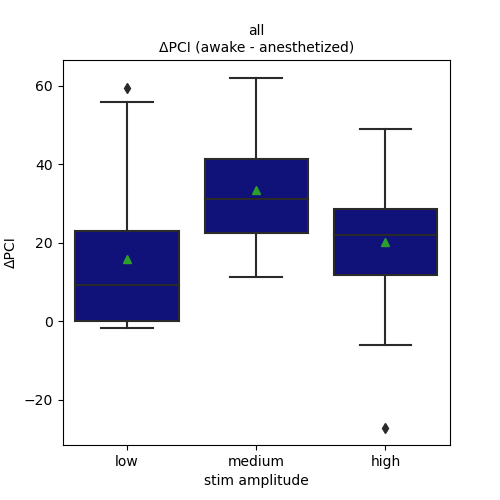

In [18]:
fig, ax = plt.subplots(figsize=(5,5))

bxplt = sns.boxplot(x='stim amplitude', y='delta_PCI', data=EEG_PCI, ax=ax, showmeans=True, color=PCImeancolor)

bxplt.set_title('{}\n\u0394PCI (awake - anesthetized)'.format(group_title))
bxplt.set_ylabel('\u0394PCI')

## Save ##
figname = 'EEG_PCI_stimamp_{}.png'.format(group_title)
fig.savefig(os.path.join(plotsdir, figname), transparent=True)